In [1]:
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
import scipy.sparse as sp
from scipy.sparse import load_npz, save_npz
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, average_precision_score
import time
from netgan import netgan
import sys
sys.path.insert(0, '../src/')
import utils

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hheidrich/miniconda3/envs/ne

#### Load the data

In [2]:
train_graph, xs = utils.load_dict('../data/datasets/eps_nn.p')

#### Parameters

In [3]:
def save_netgan_logs(log_dict, path, num_edges):
    
    overlaps = {i+1:overlap for i, overlap in enumerate(np.array(log_dict['edge_overlaps'])/num_edges)}
    timings = {i+1: timing for i, timing in enumerate(log_dict['times'])}
    
    val_perfs = np.array(log_dict['val_performances'])
    roc_aucs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,0])}
    avg_precs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,1])}
    
    dcts = {'overlap': overlaps,
            'timing': timings,
            'ROC-AUC': roc_aucs,
            'avg_prec': avg_precs,}
    
    str_len = len(str(len(log_dict['generated_graphs'])))
    Path(path).mkdir(parents=True, exist_ok=True)
    for name, dct in dcts.items():
        utils.save_dict(dct, os.path.join(path, f'{name}.pickle'))
    for i, graph in enumerate(log_dict['generated_graphs']):
        save_npz(matrix=sp.csr_matrix(graph), file=os.path.join(path, f'graph_{i+1:0{str_len}d}'))

In [4]:
def run_multiple_netgan_experiments(num_experiments,
                                    log_path,
                                    train_graph,
                                    max_iters=200000,
                                    eval_every=2000,
                                    plot_every=2000,
                                    rw_len=16,
                                    batch_size=128):
    str_len = len(str(num_experiments-1))
    walker = netgan.utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)
    for i in range(num_experiments):
        # create model
        model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=np.array([[1,2]]), val_zeros=np.array([[2,3]]),
                               stopping=1., eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        # save logs
        save_netgan_logs(log_dict=log_dict,
                         path=os.path.join(log_path, f'Experiment_{i:0{str_len}d}/sampled_graphs/'),
                         num_edges=train_graph.sum())
        
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_18.ckpt ****
**** Initializing... ****
**** Done.           ****



**** Starting training. ****


**** Iter 500    Val ROC 0.000, AP: 0.500, EO 0.052 ****
**** Iter 1000   Val ROC 1.000, AP: 1.000, EO 0.106 ****
**** Iter 1500   Val ROC 1.000, AP: 1.000, EO 0.164 ****


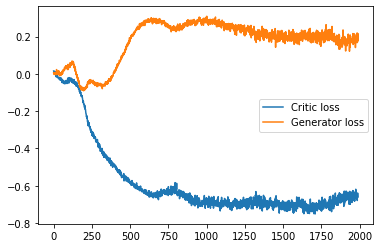

**** Iter 2000   Val ROC 1.000, AP: 1.000, EO 0.218 ****
2500   /10000    training iterations, took 242 seconds so far...
**** Iter 2500   Val ROC 1.000, AP: 1.000, EO 0.303 ****
**** Iter 3000   Val ROC 1.000, AP: 1.000, EO 0.351 ****
**** Iter 3500   Val ROC 1.000, AP: 1.000, EO 0.427 ****


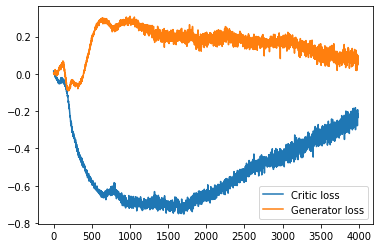

**** Iter 4000   Val ROC 1.000, AP: 1.000, EO 0.515 ****
**** Iter 4500   Val ROC 1.000, AP: 1.000, EO 0.564 ****
5000   /10000    training iterations, took 482 seconds so far...
**** Iter 5000   Val ROC 1.000, AP: 1.000, EO 0.600 ****
**** Iter 5500   Val ROC 1.000, AP: 1.000, EO 0.633 ****


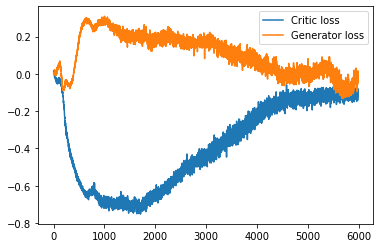

**** Iter 6000   Val ROC 1.000, AP: 1.000, EO 0.632 ****
**** Iter 6500   Val ROC 1.000, AP: 1.000, EO 0.660 ****
**** Iter 7000   Val ROC 1.000, AP: 1.000, EO 0.686 ****
7500   /10000    training iterations, took 722 seconds so far...
**** Iter 7500   Val ROC 1.000, AP: 1.000, EO 0.691 ****


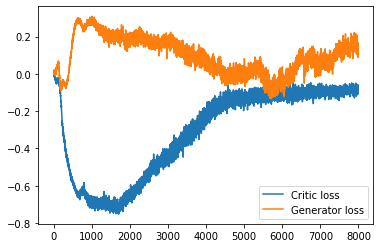

**** Iter 8000   Val ROC 1.000, AP: 1.000, EO 0.724 ****
**** Iter 8500   Val ROC 1.000, AP: 1.000, EO 0.728 ****
**** Iter 9000   Val ROC 1.000, AP: 1.000, EO 0.768 ****
**** Iter 9500   Val ROC 1.000, AP: 1.000, EO 0.773 ****


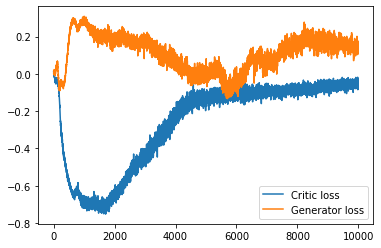

**** Training completed after 9999 iterations. ****


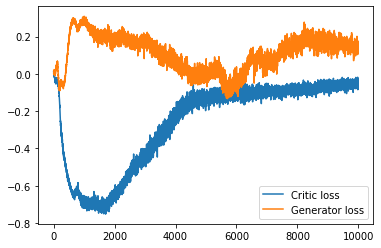

**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_19.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****
**** Iter 500    Val ROC 0.000, AP: 0.500, EO 0.053 ****
**** Iter 1000   Val ROC 0.000, AP: 0.500, EO 0.082 ****
**** Iter 1500   Val ROC 0.000, AP: 0.500, EO 0.118 ****


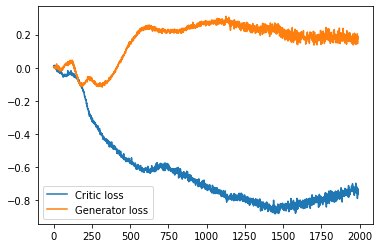

**** Iter 2000   Val ROC 1.000, AP: 1.000, EO 0.171 ****
2500   /10000    training iterations, took 239 seconds so far...
**** Iter 2500   Val ROC 1.000, AP: 1.000, EO 0.219 ****
**** Iter 3000   Val ROC 1.000, AP: 1.000, EO 0.297 ****
**** Iter 3500   Val ROC 1.000, AP: 1.000, EO 0.395 ****


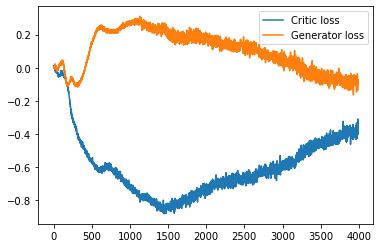

**** Iter 4000   Val ROC 1.000, AP: 1.000, EO 0.444 ****
**** Iter 4500   Val ROC 1.000, AP: 1.000, EO 0.502 ****
5000   /10000    training iterations, took 481 seconds so far...
**** Iter 5000   Val ROC 1.000, AP: 1.000, EO 0.537 ****
**** Iter 5500   Val ROC 1.000, AP: 1.000, EO 0.607 ****


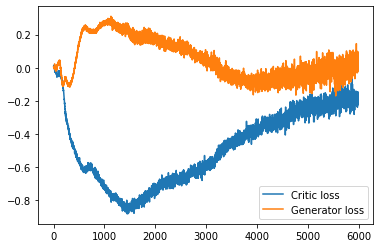

**** Iter 6000   Val ROC 1.000, AP: 1.000, EO 0.640 ****
**** Iter 6500   Val ROC 1.000, AP: 1.000, EO 0.668 ****
**** Iter 7000   Val ROC 1.000, AP: 1.000, EO 0.689 ****
7500   /10000    training iterations, took 721 seconds so far...
**** Iter 7500   Val ROC 1.000, AP: 1.000, EO 0.679 ****


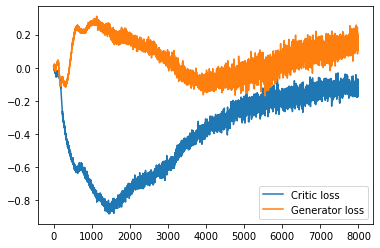

**** Iter 8000   Val ROC 1.000, AP: 1.000, EO 0.708 ****
**** Iter 8500   Val ROC 1.000, AP: 1.000, EO 0.716 ****
**** Iter 9000   Val ROC 1.000, AP: 1.000, EO 0.742 ****
**** Iter 9500   Val ROC 1.000, AP: 1.000, EO 0.752 ****


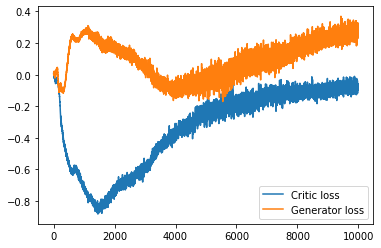

**** Training completed after 9999 iterations. ****


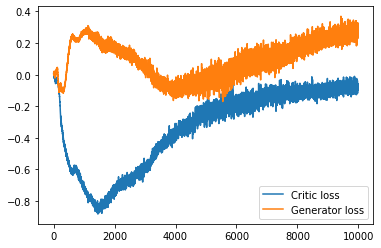

**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_20.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****
**** Iter 500    Val ROC 0.000, AP: 0.500, EO 0.046 ****
**** Iter 1000   Val ROC 0.000, AP: 0.500, EO 0.095 ****
**** Iter 1500   Val ROC 1.000, AP: 1.000, EO 0.127 ****


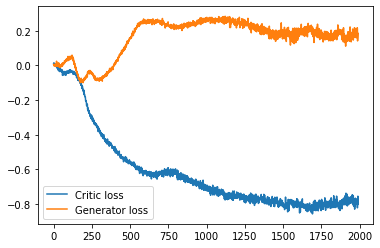

**** Iter 2000   Val ROC 1.000, AP: 1.000, EO 0.159 ****
2500   /10000    training iterations, took 237 seconds so far...
**** Iter 2500   Val ROC 1.000, AP: 1.000, EO 0.242 ****
**** Iter 3000   Val ROC 1.000, AP: 1.000, EO 0.311 ****
**** Iter 3500   Val ROC 1.000, AP: 1.000, EO 0.396 ****


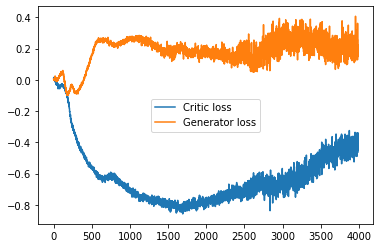

**** Iter 4000   Val ROC 1.000, AP: 1.000, EO 0.459 ****
**** Iter 4500   Val ROC 1.000, AP: 1.000, EO 0.523 ****
5000   /10000    training iterations, took 475 seconds so far...
**** Iter 5000   Val ROC 1.000, AP: 1.000, EO 0.572 ****
**** Iter 5500   Val ROC 1.000, AP: 1.000, EO 0.581 ****


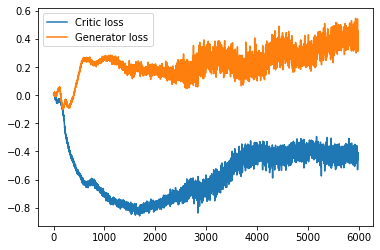

**** Iter 6000   Val ROC 1.000, AP: 1.000, EO 0.600 ****
**** Iter 6500   Val ROC 1.000, AP: 1.000, EO 0.598 ****
**** Iter 7000   Val ROC 1.000, AP: 1.000, EO 0.618 ****
7500   /10000    training iterations, took 713 seconds so far...
**** Iter 7500   Val ROC 1.000, AP: 1.000, EO 0.612 ****


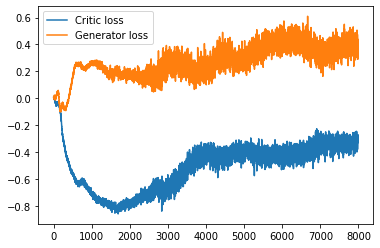

**** Iter 8000   Val ROC 1.000, AP: 1.000, EO 0.664 ****
**** Iter 8500   Val ROC 1.000, AP: 1.000, EO 0.652 ****
**** Iter 9000   Val ROC 1.000, AP: 1.000, EO 0.662 ****
**** Iter 9500   Val ROC 1.000, AP: 1.000, EO 0.675 ****


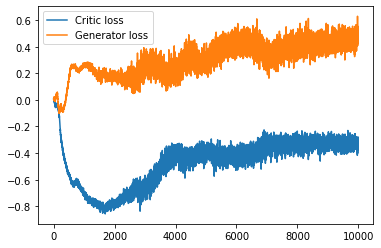

**** Training completed after 9999 iterations. ****


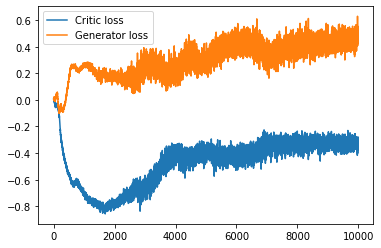

**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_21.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****
**** Iter 500    Val ROC 0.000, AP: 0.500, EO 0.058 ****
**** Iter 1000   Val ROC 0.000, AP: 0.500, EO 0.099 ****
**** Iter 1500   Val ROC 1.000, AP: 1.000, EO 0.106 ****


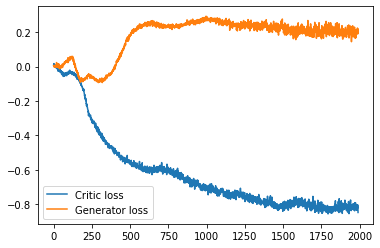

**** Iter 2000   Val ROC 1.000, AP: 1.000, EO 0.158 ****
2500   /10000    training iterations, took 236 seconds so far...
**** Iter 2500   Val ROC 1.000, AP: 1.000, EO 0.230 ****
**** Iter 3000   Val ROC 1.000, AP: 1.000, EO 0.298 ****
**** Iter 3500   Val ROC 1.000, AP: 1.000, EO 0.349 ****


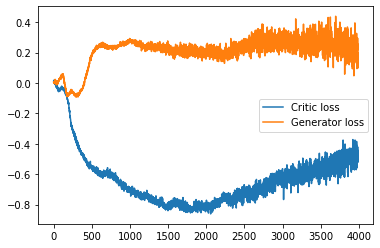

**** Iter 4000   Val ROC 1.000, AP: 1.000, EO 0.440 ****
**** Iter 4500   Val ROC 1.000, AP: 1.000, EO 0.516 ****
5000   /10000    training iterations, took 473 seconds so far...
**** Iter 5000   Val ROC 1.000, AP: 1.000, EO 0.566 ****
**** Iter 5500   Val ROC 1.000, AP: 1.000, EO 0.591 ****


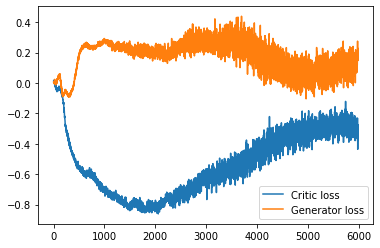

**** Iter 6000   Val ROC 1.000, AP: 1.000, EO 0.611 ****
**** Iter 6500   Val ROC 1.000, AP: 1.000, EO 0.624 ****
**** Iter 7000   Val ROC 1.000, AP: 1.000, EO 0.662 ****
7500   /10000    training iterations, took 710 seconds so far...
**** Iter 7500   Val ROC 1.000, AP: 1.000, EO 0.677 ****


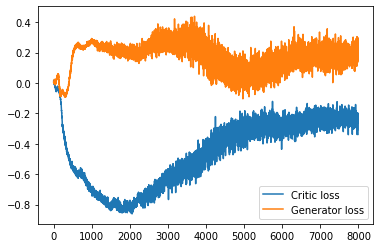

**** Iter 8000   Val ROC 1.000, AP: 1.000, EO 0.670 ****
**** Iter 8500   Val ROC 1.000, AP: 1.000, EO 0.704 ****
**** Iter 9000   Val ROC 1.000, AP: 1.000, EO 0.676 ****
**** Iter 9500   Val ROC 1.000, AP: 1.000, EO 0.711 ****


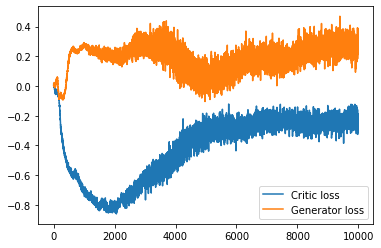

**** Training completed after 9999 iterations. ****


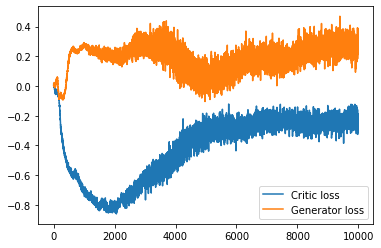

**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_22.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****
**** Iter 500    Val ROC 0.000, AP: 0.500, EO 0.044 ****
**** Iter 1000   Val ROC 1.000, AP: 1.000, EO 0.098 ****
**** Iter 1500   Val ROC 1.000, AP: 1.000, EO 0.135 ****


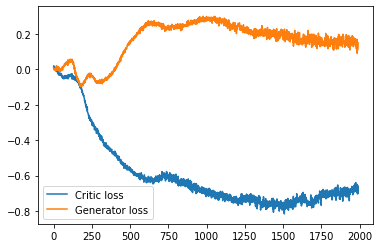

**** Iter 2000   Val ROC 1.000, AP: 1.000, EO 0.209 ****
2500   /10000    training iterations, took 243 seconds so far...
**** Iter 2500   Val ROC 1.000, AP: 1.000, EO 0.302 ****
**** Iter 3000   Val ROC 1.000, AP: 1.000, EO 0.399 ****
**** Iter 3500   Val ROC 1.000, AP: 1.000, EO 0.474 ****


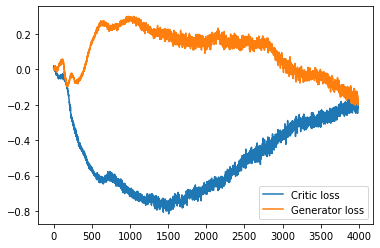

**** Iter 4000   Val ROC 1.000, AP: 1.000, EO 0.519 ****
**** Iter 4500   Val ROC 1.000, AP: 1.000, EO 0.567 ****
5000   /10000    training iterations, took 487 seconds so far...
**** Iter 5000   Val ROC 1.000, AP: 1.000, EO 0.597 ****
**** Iter 5500   Val ROC 1.000, AP: 1.000, EO 0.626 ****


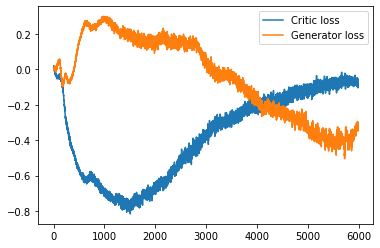

**** Iter 6000   Val ROC 1.000, AP: 1.000, EO 0.679 ****
**** Iter 6500   Val ROC 1.000, AP: 1.000, EO 0.673 ****
**** Iter 7000   Val ROC 1.000, AP: 1.000, EO 0.698 ****
7500   /10000    training iterations, took 730 seconds so far...
**** Iter 7500   Val ROC 1.000, AP: 1.000, EO 0.710 ****


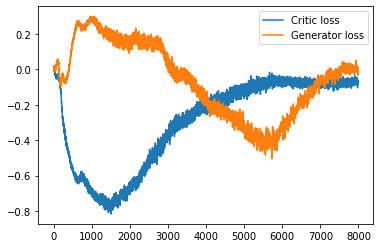

**** Iter 8000   Val ROC 1.000, AP: 1.000, EO 0.714 ****
**** Iter 8500   Val ROC 1.000, AP: 1.000, EO 0.740 ****
**** Iter 9000   Val ROC 1.000, AP: 1.000, EO 0.755 ****
**** Iter 9500   Val ROC 1.000, AP: 1.000, EO 0.769 ****


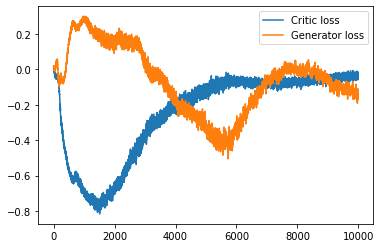

**** Training completed after 9999 iterations. ****


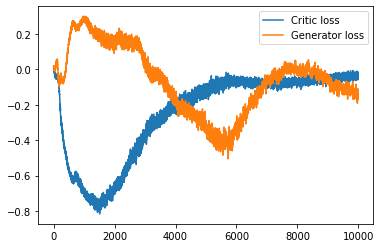

In [5]:
run_multiple_netgan_experiments(num_experiments=5,
                                log_path='../logs/eps_nn/NetGan',
                                train_graph=train_graph,
                                eval_every=500,
                                max_iters=10000)

In [10]:
def train_to_eo_and_save_models(target_eo, num_models):
    for i in range(num_models):
        saver = tf.train.Saver()
        # create model
        model = netgan.NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0,
                              use_gumbel=True, disc_iters=3, W_down_discriminator_size=128,
                              W_down_generator_size=128, l2_penalty_generator=1e-7,
                              l2_penalty_discriminator=5e-5, generator_layers=[40],
                              discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=np.array([[1,2]]), val_zeros=np.array([[2,3]]),
                               stopping=target_eo, eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        #save_model
        _ = saver.save(model.session, f'../netgan_models_eo_{int(100*target_eo)}/model_{i}.ckpt')
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()